In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [2]:
PATH = './'
GRANULARITY = 'month'

In [3]:
df = pd.read_csv(
    PATH+'BI Challenge Data.csv',
    sep=',',
    parse_dates = ['createDate','assignedDate','completedDate'],
    dtype = {
        'taskID': 'object',
        'workerID': 'object',
        'posterID': 'object',
        'bidCount': 'int32',
        'postPrice': 'float64',
        'assignedPrice': 'float64',
    }
)

In [4]:
# "some of the tasks are missing completed_at timestamps which should be ignored"
df = df[df['completedDate'].notnull()]
# only 4 records missing assignedDate
df = df[df['assignedDate'].notnull()]
# 2% of remaining records are missing worker ID
# hard to measure retention if there is no key!
df = df[df['workerID'].notnull()]
# all remaining posterIDs are present
# 1 assignedPrice is missing, drop it
df = df[df.assignedPrice.notnull()]
# are these corporate employee tests? or actually workers posting tasks?
# there are only 10, dropping them
df = df[(df['workerID']!=df['posterID'])]

In [5]:
df.set_index('taskID', verify_integrity=True, inplace=True)

In [6]:
# DATETIME FEATURE GENERATION
df['taskResponseTime'] = df['assignedDate'] - df['createDate']
df['taskTime'] = df['completedDate'] - df['assignedDate']
df['taskTotalTime'] = df['completedDate'] - df['createDate']

In [7]:
# seems like tasks can be unassigned to a worker but nevertheless completed..
# ask Eng about why that isn't being tracked properly
# only 4 records here
# fill in assignedDate with createDate because they're often very close
df['assignedDate'] = df['assignedDate'].fillna(df['createDate'])
df['taskResponseTime'] = df['assignedDate'] - df['createDate']

In [8]:
# how can 20% of tasks be completed without any bids?
# bidCount doesn't seem to be very reliable..
# of the bidCount=0 records, 97% have an unreasonably fast assignedDate
df.loc[df['bidCount']<=0, 'bidCount'] = np.nan

In [9]:
# assigned date seems.. suspiciously fast when bidCount is <0
# (df[df.bidCount.isnull()]['taskResponseTime']) < '1 second').sum() / len(df[df.bidCount.isnull()]
# make assignedDate with 0 bidCount nan for now
df.loc[df['bidCount'].isnull(), 'assignedDate'] = np.nan

In [10]:
df['priceRatio'] = df['assignedPrice'] / df['postPrice']

In [11]:
# 40% of tasks were completed for LESS than they were posted
#(df['priceRatio'] < 1.0).sum() / len(df)
# 57% of tasks were completed for MORE than they were posted
#(df['priceRatio'] > 1.0).sum() / len(df)

In [12]:
# HIGHER priceRatio means the poster paid MORE than what they expected to
# these posters must have been surprised with how expensive their task was
df['priceRatio'] = np.where(df['priceRatio'] >= 4, 4, df['priceRatio'])
# these posters were pleasantly suprised with how cheap their task was
# or maybe frauding the system? unclear.. 
df['priceRatio'] = np.where(df['priceRatio'] <= 0.25, 0.25, df['priceRatio'])

In [13]:
def cohort_date(sr, granularity):
    """
    Helper function to make nicely formatted strings for referring to cohorts
    """
    if granularity=='year':
        return sr.apply(lambda d: f'{d.year}')
    elif granularity=='quarter':
        return sr.apply(lambda d: f'{d.year} Q{(d.month-1)//3 + 1}')
    elif granularity=='month':
        return sr.apply(lambda d: d.strftime('%Y-%m'))
    else:
        raise("Incompatible granularity. Use 'year', 'quarter', or 'month'.")

In [14]:
# identify the users' first task, so we can determine "signup date"
df['workerTaskNumber'] = df.groupby('workerID')['createDate'].rank()
df['posterTaskNumber'] = df.groupby('posterID')['createDate'].rank()
df['taskPeriod'] = cohort_date(df['createDate'], granularity=GRANULARITY)

In [15]:
# pandas gives "FutureWarning: using a dict with renaming is deprecated"
from warnings import filterwarnings
filterwarnings('ignore')

In [16]:
# define a bunch of aggregations we can pull for each CUSTOMER
poster_aggregations = {
    'createDate':{
        'taskCount': 'count',
        'firstTaskDate': lambda d: d.min(),
    },
    'assignedPrice':{
        'paidTotal': 'sum',
        'paidMedian': 'median',
        'paidAvg': 'mean',
        'paidStdDev': 'std',
    },
    'taskTotalTime':{
        'medianTimeToComplete': pd.Series.median,
        'avgTimeToComplete': pd.Series.mean,
        'stddevTimeToComplete': pd.Series.std,
    },
    'bidCount':{
        'avgBidCount': 'mean',
        'maxBidCount': 'max',
        'minBidCount': 'min',  
    },
    'priceRatio':{
        'avgPriceRatio': 'mean',
    },
    'completedDate':{
        'weekendCompletionProportion': lambda d: d.apply(lambda d: float(d.dayofweek in [5,6])).mean()
    },
}

In [17]:
customers = df.groupby('posterID').agg(poster_aggregations)
customers.columns = customers.columns.droplevel()
customers['cohort'] = cohort_date(customers['firstTaskDate'], GRANULARITY)
customers.head().T

posterID,10,100011,100016,100033,100035
taskCount,17,5,5,2,10
firstTaskDate,2013-07-22 23:32:24.945000,2014-03-16 03:50:52.279000,2014-09-02 22:19:59.107000,2014-03-23 01:29:47.944000,2014-03-16 08:28:54.849000
paidTotal,893,566,661,264,790
paidMedian,45,97,120,132,74.5
paidAvg,52.5294,113.2,132.2,132,79
paidStdDev,29.0024,54.2927,55.138,4.24264,34.6506
medianTimeToComplete,0 days 19:13:34.169000,2 days 18:15:48.325000,1 days 06:15:05.815000,1 days 01:05:28.164500,1 days 06:34:11.756500
avgTimeToComplete,0 days 23:20:43.495352,5 days 10:19:45.609600,1 days 23:40:58.642800,1 days 01:05:28.164500,2 days 21:34:16.238100
stddevTimeToComplete,1 days 00:24:14.118835,5 days 08:59:33.558979,1 days 20:31:00.661846,0 days 00:54:07.330616,3 days 23:06:25.684507
avgBidCount,2.82353,1.8,2,2,2.4


In [18]:
# define a bunch of aggregations we can pull for each TASKER
worker_aggregations = {
    'createDate':{
        'taskCount': 'count',
        'firstTaskDate': lambda d: d.min(),
    },
    'assignedPrice':{
        'earnTotal': 'sum',
        'earnMedian': 'median',
        'earnAvg': 'mean',
        'earnStdDev': 'std',
    },
    'taskTime':{
        'medianTaskTime': pd.Series.median,
        'avgTaskTime': pd.Series.mean,
        'stddevTaskTime': pd.Series.std,
    },
    'bidCount':{
        'avgBidCount': 'mean',
        'maxBidCount': 'max',
        'minBidCount': 'min',  
    },
    'priceRatio':{
        'avgPriceRatio': 'mean',
    },
    'completedDate':{
        'weekendCompletionProportion': lambda d: d.apply(lambda d: float(d.dayofweek in [5,6])).mean()
    },
}

In [19]:
workers = df.groupby('workerID').agg(worker_aggregations)
workers.columns = workers.columns.droplevel()
workers['cohort'] = cohort_date(workers['firstTaskDate'], GRANULARITY)
workers.head().T

workerID,100074,100109,100124,100175,100227
taskCount,1,5,6,3,1
firstTaskDate,2014-03-28 19:14:13.578000,2014-06-18 21:47:55.683000,2014-03-14 05:35:44.635000,2015-09-17 08:05:50.981000,2014-03-17 05:31:09.956000
earnTotal,56,473,981,478,152
earnMedian,56,44,60,138,152
earnAvg,56,94.6,163.5,159.333,152
earnStdDev,NaN,122.468,265.595,109.569,NaN
medianTaskTime,6 days 23:54:38.007000,2 days 09:00:43.676000,1 days 14:57:45.576500,7 days 00:37:42.833000,3 days 19:43:28.598000
avgTaskTime,6 days 23:54:38.007000,8 days 05:56:28.176600,16 days 22:05:40.625500,13 days 07:35:57.039000,3 days 19:43:28.598000
stddevTaskTime,NaT,12 days 20:44:17.324451,37 days 07:32:47.245312,12 days 14:13:21.573639,NaT
avgBidCount,10,3.5,2,4,1


In [20]:
def plot_growth(df, key, entity, granularity):
    
    summary = df.groupby('taskPeriod').agg({
        key: {
            'actives': pd.Series.nunique,
            'tasks': 'count',
        },
        'createDate': {
            'date': lambda d: d.min().strftime('%Y-%m-%d')
        }
    })
    summary.columns = summary.columns.droplevel()
    
    summary[f'{entity}'] = summary['actives']

    plt.plot(summary.date, summary[f'{entity}'])
    plt.xticks(summary.date, summary.index.values, rotation=45)
    plt.ylabel(f'Users per {granularity}')


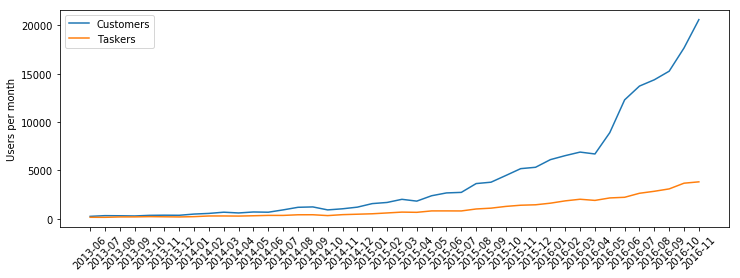

In [21]:
plt.figure(figsize=(12, 4))
plot_growth(df, 'posterID', 'Customers', GRANULARITY)
plot_growth(df, 'workerID', 'Taskers', GRANULARITY)
plt.legend()

In [22]:
def plot_tasks(df, key, entity, granularity):
    
    plt.title(f'Task Frequency')
    summary = df.groupby('taskPeriod').agg({
        key: {
            'actives': pd.Series.nunique,
            'tasks': 'count',
        },
        'createDate': {
            'date': lambda d: d.min().strftime('%Y-%m-%d')
        }
    })
    summary.columns = summary.columns.droplevel()
    
    summary[f'{entity}'] = summary['tasks'] / summary['actives']

    plt.plot(summary.date, summary[f'{entity}'])
    plt.xticks(summary.date, summary.index.values, rotation=45)
    plt.ylabel(f'Tasks per {granularity}')


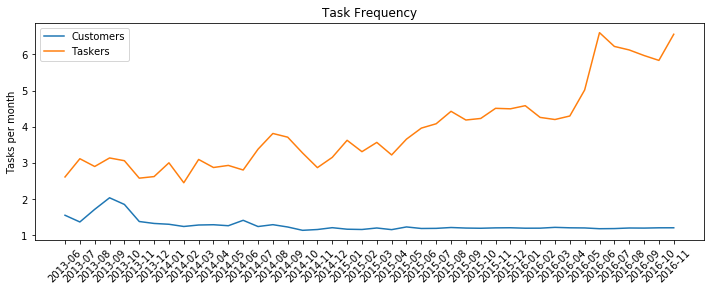

In [23]:
plt.figure(figsize=(12, 4))
plot_tasks(df, 'posterID', 'Customers', GRANULARITY)
plot_tasks(df, 'workerID', 'Taskers', GRANULARITY)
plt.legend()

In [24]:
def cohort_period(df):
    # TODO check for counts consistency here, perhaps with a matrix
    df['cohortPeriod'] = np.arange(len(df)) + 1
    return df

def calculate_retention(df, users, key):
    """
    Takes joined tasks + users (workers or customers) and the ID to count them with
    Returns summarized cohort information and trianglar retention matrix
    Referenced from: http://www.gregreda.com/2015/08/23/cohort-analysis-with-python/
    """
    merged = pd.merge(df, users, left_on=key, right_index=True)
    assert len(merged)==len(df)
    grouped = merged.groupby(['cohort', 'taskPeriod'])

    cohorts = grouped.agg({
        key: pd.Series.nunique,
        'createDate': len,
        'assignedPrice': np.sum,
    })
    cohorts.columns = ('actives','tasks','taskRevenue')
    
    cohorts = cohorts.groupby(level=0).apply(cohort_period)
    cohorts.reset_index(inplace=True)
    cohorts.set_index(['cohort', 'cohortPeriod'], inplace=True)
    
    cohort_group_size = cohorts['actives'].groupby(level=0).first()
    
    retention = cohorts['actives'].unstack(0).divide(cohort_group_size, axis='columns')
    
    return retention, cohorts

In [25]:
customer_retention, customer_cohorts = calculate_retention(df, customers, 'posterID')
worker_retention, worker_cohorts = calculate_retention(df, workers, 'workerID')

In [26]:
def plot_retention(retention, entity):
    plt.figure(figsize=(20, 10))
    plt.title(f'{entity} Retention')
    sns.heatmap(
        retention.T,
        mask=retention.T.isnull(), annot=True, fmt='.0%',
        cmap=sns.cm.rocket_r
    )

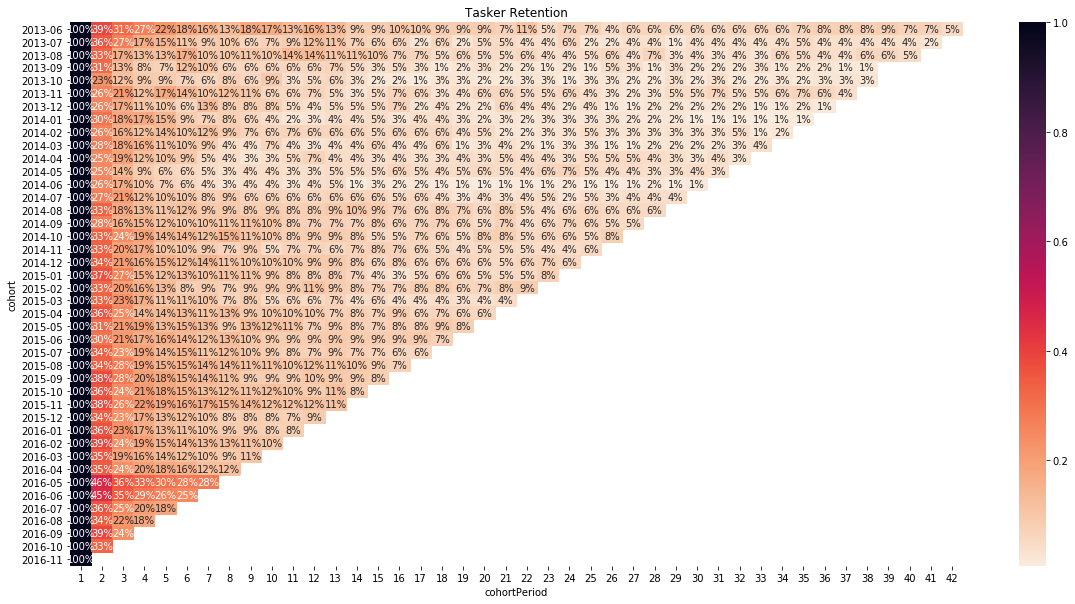

In [27]:
plot_retention(worker_retention, 'Tasker')

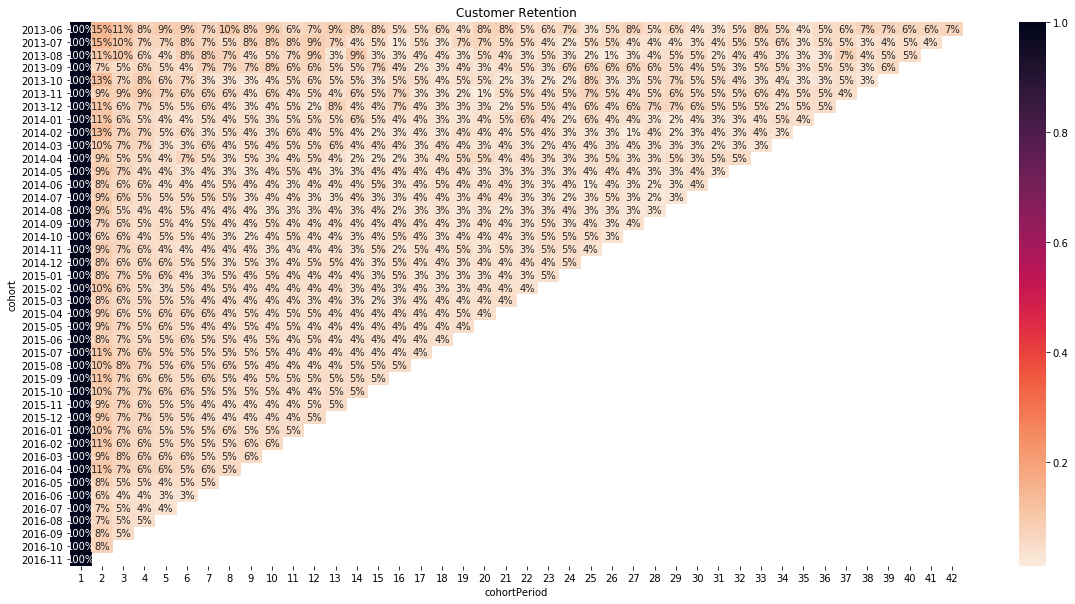

In [28]:
plot_retention(customer_retention, 'Customer')